### ANCOVA Notebook

This notebook introduces and demonstrates how to perform and interpret an Analysis of Covariance (ANCOVA). ANCOVA is a powerful statistical technique that blends ANOVA and linear regression. It helps compare group means while adjusting for the effects of a continuous variable, known as a covariate. In this example, we explore how median housing values vary across NYC boroughs after accounting for the percentage of people with less than a high school education.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import anova_lm

In [ ]:
df = pd.read_csv(r"path")

In [5]:
df.columns

Index(['INTPTLAT', 'INTPTLON', 'GISJOIN', 'YEAR', 'Median_age', 'Population',
       'WhiteAlone', 'BlackAlone', 'NativeAlone', 'BlackAlonWithComb',
       'Hisp_Latino', 'MedHouseholdIncome', 'PerCapitaIncome', 'MedYearBuilt',
       'MedianValue', 'PctNonWhite', 'PctBlackOnly', 'PctHisLatOnly',
       'HsngUnits', 'HsngDenPerHac', 'pop_65above', 'Fem_65Above',
       'Commute30Over', 'commute60Over', 'commutePtransitOver60',
       'commuteWalkBike', 'LivingAloneOver65', 'LessThanHighSchool',
       'TotPopulation', 'pct_fem65Over', 'pct_popOver65', 'pctCommute60Over',
       'pctCommutePTnsitOver60', 'pctCommuteWalkBike', 'pct_LivingAlone65Over',
       'pct_LessThanHighSchool', 'pctMobileHomes', 'BlcokG_Area_SqMeter',
       'WaterFront', 'NearParks', 'NearMajorParks', 'boro_name'],
      dtype='object')

In [11]:
# make sure the numerical columns are numerical. Medianvalue columns needs some attention.
df['MedianValue'] = pd.to_numeric(df['MedianValue'],errors ='coerce')

### Exploring the Data

Before analysis, visualizing the relationships between the variables helps uncover patterns and potential assumptions.

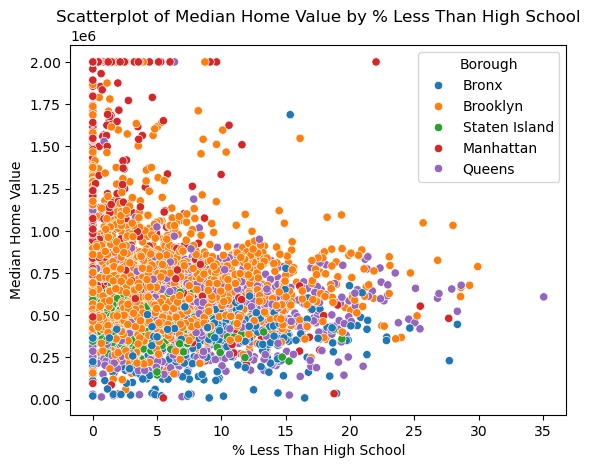

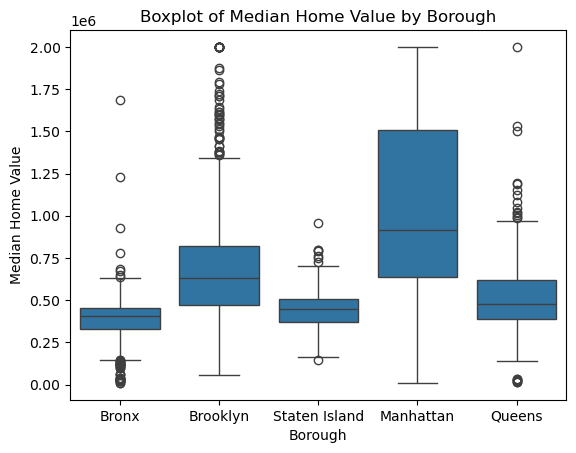

In [12]:
# 2. Visualize the data
sns.scatterplot(data=df, x='pct_LessThanHighSchool', y='MedianValue', hue='boro_name')
plt.title('Scatterplot of Median Home Value by % Less Than High School')
plt.xlabel('% Less Than High School')
plt.ylabel('Median Home Value')
plt.legend(title='Borough')
plt.show()

# Boxplot of Median Home Value by Borough
sns.boxplot(data=df, x='boro_name', y='MedianValue')
plt.title('Boxplot of Median Home Value by Borough')
plt.xlabel('Borough')
plt.ylabel('Median Home Value')
plt.show()

### What is ANCOVA?

ANCOVA, or Analysis of Covariance, is used to:
- Test for differences in means between groups
- Control for continuous covariates that may influence the dependent variable
- Increase statistical power by reducing within-group error variance

In our case, ANCOVA helps us determine if boroughs differ in median home values, *after controlling for educational attainment*.

In [27]:
len(df)

4352

In [26]:
# drop nan for trhe three values of interest
df.dropna(subset=['MedianValue','boro_name','pct_LessThanHighSchool'],inplace=True)
# also make sure to remove median value of 0
df=df.loc[df['MedianValue']>0].copy()

In [28]:
# 4. Fit ANCOVA model (no interaction)
model = smf.ols('MedianValue ~ C(boro_name) + pct_LessThanHighSchool', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MedianValue   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     405.8
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        12:44:09   Log-Likelihood:                -60888.
No. Observations:                4352   AIC:                         1.218e+05
Df Residuals:                    4346   BIC:                         1.218e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

### ANCOVA Table

This shows the contribution of each factor to explaining variance in median home value.

In [29]:
# 5. Run ANOVA table for model comparison
anova_results = anova_lm(model)
print("\nANCOVA Table:")
print(anova_results)


ANCOVA Table:
                            df        sum_sq       mean_sq           F  \
C(boro_name)               4.0  1.665867e+14  4.164667e+13  500.261629   
pct_LessThanHighSchool     1.0  2.321450e+12  2.321450e+12   27.885360   
Residual                4346.0  3.618036e+14  8.324979e+10         NaN   

                              PR(>F)  
C(boro_name)            0.000000e+00  
pct_LessThanHighSchool  1.350079e-07  
Residual                         NaN  


### Comparing ANOVA, Regression, and ANCOVA

- **ANOVA**: Tests group differences using categorical predictors only.
- **Regression**: Uses only continuous variables.
- **ANCOVA**: Combines both to test group differences *adjusted for* continuous covariates.

### Testing for Interaction Effects

Before trusting an ANCOVA model, we test if the covariate’s relationship with the dependent variable is consistent across groups. If not, the ANCOVA assumption of homogeneous slopes is violated.


Interaction effect test:
   df_resid           ssr  df_diff       ss_diff         F        Pr(>F)
0    4346.0  3.618036e+14      0.0           NaN       NaN           NaN
1    4342.0  3.505352e+14      4.0  1.126841e+13  34.89482  1.009580e-28


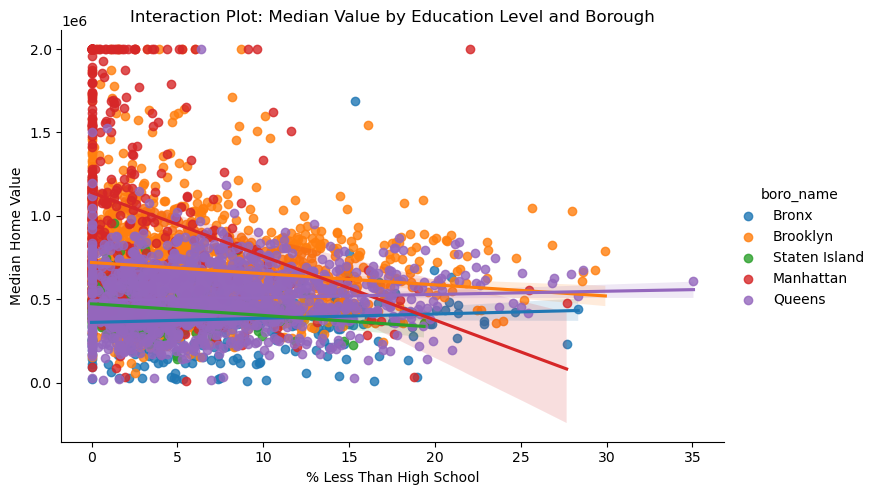

In [30]:
# 7. Check if interaction is needed (does the covariate effect differ by group?)
model_interaction = smf.ols('MedianValue ~ C(boro_name) * pct_LessThanHighSchool', data=df).fit()
interaction_anova = anova_lm(model, model_interaction)
print("\nInteraction effect test:")
print(interaction_anova)

# Plot interaction (if any)
sns.lmplot(data=df, x='pct_LessThanHighSchool', y='MedianValue', hue='boro_name', aspect=1.5)
plt.title('Interaction Plot: Median Value by Education Level and Borough')
plt.xlabel('% Less Than High School')
plt.ylabel('Median Home Value')
plt.show()

### Interpreting the Interaction Test

If the interaction is significant, we cannot interpret ANCOVA main effects directly. Instead, we need to analyze the effect of the covariate *within each group*.

In [31]:
# 8. Interpret the interaction
if interaction_anova.loc[1, 'Pr(>F)'] < 0.05:
    print("\nSignificant interaction detected. The effect of education level on median home value differs by borough.")
else:
    print("\nNo significant interaction. Proceed with standard ANCOVA interpretation.")


Significant interaction detected. The effect of education level on median home value differs by borough.


### Post Hoc Tests

If there's no significant interaction, and boroughs still differ significantly, we can perform a post hoc Tukey HSD test to compare which boroughs differ from each other in adjusted means.

In [34]:
# 9. Post hoc test (Tukey HSD) - only valid if no interaction and categorical variable is significant
mc = MultiComparison(df['MedianValue'], df['boro_name'])
tukey_result = mc.tukeyhsd()
print(tukey_result.summary())

# Plot Tukey HSD results
tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
tukey_df[['meandiff', 'lower', 'upper']] = tukey_df[['meandiff', 'lower', 'upper']].astype(float)



            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
  group1      group2      meandiff   p-adj     lower        upper     reject
----------------------------------------------------------------------------
    Bronx      Brooklyn  299453.9306    0.0  258381.8263  340526.0348   True
    Bronx     Manhattan  678029.6579    0.0  628784.6048  727274.7111   True
    Bronx        Queens   123801.889    0.0   82425.1534  165178.6245   True
    Bronx Staten Island   71096.7147 0.0097   11660.1487  130533.2807   True
 Brooklyn     Manhattan  378575.7274    0.0  339405.2861  417746.1686   True
 Brooklyn        Queens -175652.0416    0.0 -204310.0676 -146994.0156   True
 Brooklyn Staten Island -228357.2159    0.0 -279757.1535 -176957.2783   True
Manhattan        Queens  -554227.769    0.0  -593717.514 -514738.0239   True
Manhattan Staten Island -606932.9432    0.0 -665071.6661 -548794.2204   True
   Queens Staten Island  -52705.1743 0.0428 -104348.8581   -1061.4904   True

In [33]:
# Evaluate appropriateness of post hoc test
if interaction_anova.loc[1, 'Pr(>F)'] < 0.05:
    print("\nCaution: Significant interaction detected — group mean differences may vary by covariate levels. Interpret post hoc results carefully.")
elif anova_results.loc['C(boro_name)', 'PR(>F)'] >= 0.05:
    print("\nNo significant group differences found. Post hoc results may not be meaningful.")
else:
    print("\nPost hoc test confirms where group differences lie after adjusting for covariate.")


Caution: Significant interaction detected — group mean differences may vary by covariate levels. Interpret post hoc results carefully.


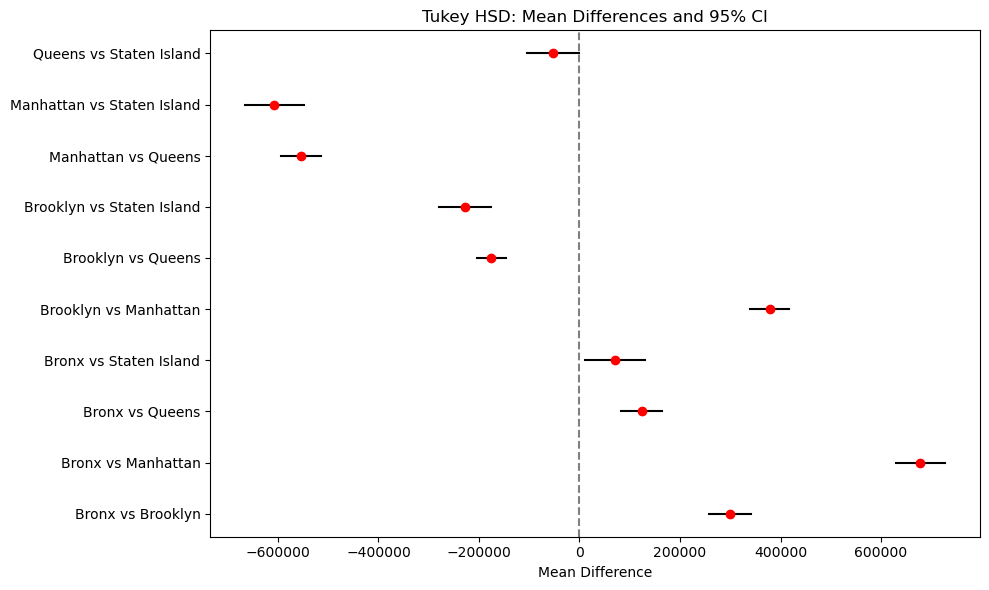

In [35]:
plt.figure(figsize=(10, 6))
for i, row in tukey_df.iterrows():
    plt.plot([row['lower'], row['upper']], [i, i], color='black')
    plt.plot(row['meandiff'], i, 'ro')
plt.yticks(range(len(tukey_df)), tukey_df['group1'] + ' vs ' + tukey_df['group2'])
plt.axvline(x=0, linestyle='--', color='gray')
plt.title('Tukey HSD: Mean Differences and 95% CI')
plt.xlabel('Mean Difference')
plt.tight_layout()
plt.show()

### Final Thoughts

ANCOVA enhances our ability to make fair comparisons across groups by adjusting for relevant continuous variables. However, it's essential to:
- Check for interaction (slope heterogeneity)
- Use post hoc tests only if appropriate
- Inspect model assumptions to ensure valid conclusions

### Interpreting Diagnostic and Post Hoc Plots

At the end of this notebook, we visualize results and diagnostics using three important plots. Here's how to interpret each:

#### 1. **Tukey HSD Plot**
This plot displays the pairwise mean differences between boroughs, along with 95% confidence intervals.
- Each line represents a comparison between two boroughs.
- The red dot is the estimated mean difference.
- The horizontal line shows the confidence interval.
- If a confidence interval crosses zero (gray dashed vertical line), the difference between those two groups is **not statistically significant**.
- Otherwise, it suggests a significant difference in housing values between those boroughs **after adjusting for education level**.

Use this plot to understand which boroughs are driving the overall group difference.

#### 2. **Residuals vs Fitted Plot**
This diagnostic checks for **homoscedasticity**—whether residuals have equal variance across fitted values.
- The red dashed line represents zero residuals.
- A random scatter (no clear pattern or funnel shape) indicates that the assumption of equal variance is likely satisfied.
- Patterns (e.g., curves or cones) suggest model misfit or heteroscedasticity.

#### 3. **Histogram of Residuals** & **Q-Q Plot**
These plots assess whether residuals are approximately **normally distributed**, which is another key ANCOVA assumption.
- The histogram should resemble a bell curve.
- The Q-Q (quantile-quantile) plot should have points that fall roughly along the 45-degree line.
- Deviations from the line in the Q-Q plot suggest that residuals are skewed or have heavy tails, which may impact validity.

Together, these plots help validate your model assumptions and ensure that ANCOVA results are trustworthy. If assumptions are violated, consider transforming variables or using more robust methods.


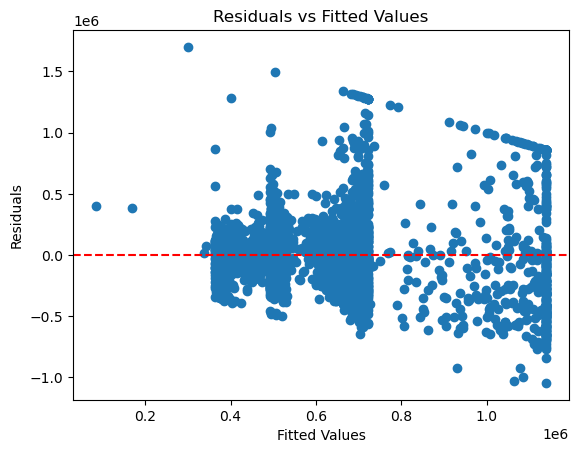

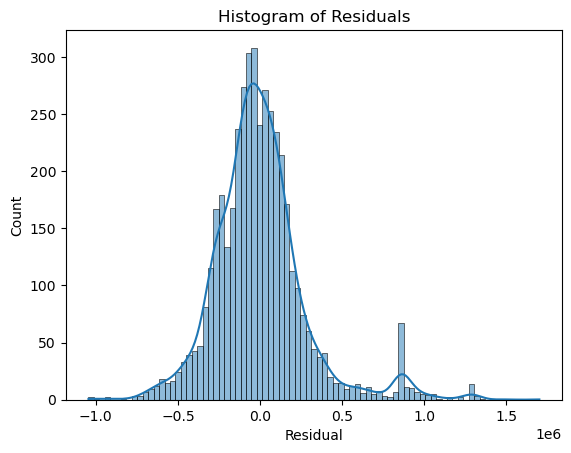

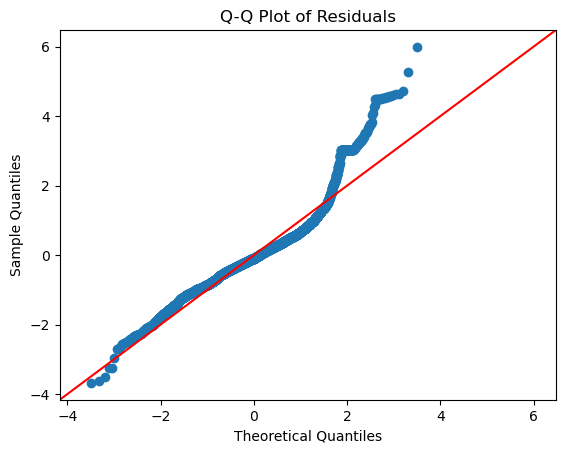

In [18]:
# 11. Assumption checks: plot residuals
residuals = model_interaction.resid
fitted = model_interaction.fittedvalues

plt.scatter(fitted, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()